## Task 3 — Data Augmentation and Feature Engineering (30 points)

> First Practice: Time‑Warp Data Augmentation (Probabilistic Compression/Stretching)

- Creates additional static copies of ECG signals *for the training set only* by compressing or stretching their time axis, enhancing robustness to heart rate variations.
- **Trajectory:**
   - Load original data (`X_orig`, `y_orig`).
   - **Split:** A **stratified** train/validation split is performed on the original data to create a clean training set and validation set.
   - **Train Set Augmentation:** The `time_compress_stretch` function is applied with various rates (e.g., `[0.8, 0.9, 1.1, 1.2]`) *only to the signals in the training set*. This creates a new set of augmented signals.
   - **Combine Training Data:** The newly created augmented signals are added to the original training signals to form the final, expanded training dataset. The corresponding labels are duplicated.
   - **Validation Set Integrity:** The validation set contains *only* the original, un-augmented signals from the split, ensuring an unbiased evaluation of the model's performance on clean data.

- **Reasoning:**
   - **Avoids Data Leakage:** Augmenting *after* splitting the data prevents any synthetic information from leaking into the validation set, which would lead to overly optimistic performance metrics.
   - **Heart Rate Robustness:** Stretching and compressing the time axis simulates natural physiological variations like tachycardia (faster heart rate) and bradycardia (slower heart rate), forcing the model to learn rate-invariant features.
   - **Increased Data Diversity:** Substantially expands the size and variety of the training dataset with plausible, synthetic examples.
   - **Label Preservation:** This augmentation changes the signal's duration but does not alter the underlying arrhythmia class (e.g., Atrial Fibrillation remains Atrial Fibrillation, just faster or slower).

---
> Second Practice: Gaussian Noise Augmentation

- Adds a small amount of random Gaussian noise to ECG signals *dynamically during training* to improve the model's resilience to real-world sensor noise and recording imperfections.
- **Trajectory:**
   - **On-the-fly Augmentation:** This is implemented within a custom collate function (`prep_batch_noisy_shifting`) which is passed to the `train_loader`. It dynamically adds noise to each signal in every batch just before it is fed to the model.
   - **Validation Purity:** The `val_loader` uses a separate, standard collate function (`prep_batch`) that does **not** add noise, ensuring that validation is performed on clean, original-like data for a fair and consistent assessment.
   - **Noise Control:** The intensity of the noise is controlled by a `noise_std` parameter, allowing for fine-tuning of the augmentation strength.

- **Reasoning:**
   - **Simulates Real-world Noise:** Effectively mimics the random electrical noise and artifacts commonly found in clinical ECG recordings.
   - **Improves Model Robustness:** By training on slightly corrupted signals, the model learns to focus on the underlying ECG morphology and ignore minor perturbations, leading to better generalization and less overfitting.
   - **Dynamic Diversity:** Since the noise is generated randomly for each batch in every epoch, the model sees a virtually infinite variety of noisy versions of the same signal, which is a more efficient form of augmentation than creating static noisy copies.

---
> Third Practice: Hand-Crafted Statistical Features

- Enriches the model's input by combining learned features from the CNN-GRU with explicit, hand-crafted statistical features extracted directly from the raw signal.
- **Trajectory:**
   - **Model Architecture:** The `BaselineSTFTFeaturedModel` is used, which is designed to handle two parallel input streams.
   - **Feature Extraction:** For each raw signal in a batch, the `_extract_simplified_hrv_features` method calculates a set of 5 statistical values: **Skewness**, **Kurtosis**, **Interquartile Range (IQR)**, and the **lag and value of the first significant autocorrelation peak**.
   - **Feature Normalization:** These 5 features are passed through a `BatchNorm1d` layer to stabilize their scale and distribution across batches.
   - **Feature Concatenation:** The primary feature vector from the GRU's final hidden state is **concatenated** with the normalized vector of hand-crafted features.
   - **Final Classification:** This combined, richer feature vector is then fed into the final fully-connected layer for classification.

- **Reasoning:**
   - **Complementary Information:** Fuses the powerful, automatically learned hierarchical features from the deep learning backbone with interpretable, domain-relevant statistical metrics. The deep model learns "what to look for," while the statistical features provide explicit, global properties of the signal.
   - **Morphology and Rhythm Clues:** Skewness, Kurtosis, and IQR describe the shape and spread of the signal's amplitude distribution. Autocorrelation provides a robust proxy for signal periodicity and rhythm, helping to distinguish between regular and irregular heartbeats.
   - **Enhanced Representation:** By providing this explicit information, the model doesn't have to learn these fundamental statistical properties from scratch, potentially freeing up capacity to learn more complex patterns and improving overall accuracy.

---
> Fourth Practice: Time Shifting

- Randomly shifts the ECG signal left or right along the time axis *dynamically during training* to make the model invariant to the exact position of features within the recording window.
- **Trajectory:**
   - **On-the-fly Augmentation:** This technique is implemented alongside Gaussian noise in the `prep_batch_noisy_shifting` collate function used by the `train_loader`.
   - **Random Shift:** For each signal in a batch, a random integer shift amount is chosen, up to a `max_shift_fraction` of the total signal length (e.g., up to 10% left or right).
   - **Zero Padding:** The signal is then shifted by rolling the data and padding the newly empty space with zeros. For a right shift, zeros are padded at the beginning; for a left shift, zeros are padded at the end.
   - **Validation Integrity:** The `val_loader` does not use this shifting, ensuring evaluation is performed on the original, unshifted signals.

- **Reasoning:**
   - **Positional Invariance:** Helps the model recognize an arrhythmia pattern (e.g., an AF episode) regardless of whether it starts at the beginning, middle, or end of the input window.
   - **Regularization:** Acts as a powerful regularizer by preventing the model from overfitting to the specific alignment of patterns in the training data.
   - **Simulates Realistic Scenarios:** In practice, the windowing of a continuous ECG signal is arbitrary. This augmentation simulates this reality, leading to a more robust model.
   - **Dynamic Application:** Applying the shift dynamically ensures the model sees a different alignment for each signal in every epoch, maximizing the utility of the augmentation.

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import numpy as np
from scipy.interpolate import interp1d

def time_compress_stretch(signal, rate=0.8):
    """
    Applies time compression or stretching to a 1D time series signal.

    This technique, often referred to as time stretching/compression or time warping,
    simulates natural variations in the speed or duration of events within a time series.
    By altering the temporal dimension, it helps the model become more robust to the
    precise "sampling" or timing of the signal, enhancing its invariance to time deformation.[1]

    Args:
        signal (np.ndarray): The input 1D time series signal.
        rate (float): The compression rate. A rate < 1.0 compresses the signal
                      (makes it shorter/faster), while a rate > 1.0 stretches it
                      (makes it longer/slower). Default is 0.8 for compression.

    Returns:
        np.ndarray: The time-compressed signal.
    """
    original_length = len(signal)
    new_length = int(original_length * rate)

    # Create original time points (indices)
    original_time_points = np.arange(original_length)

    # Create new time points for the compressed signal
    # These points will span the original signal's "time" but with a new number of steps
    new_time_points = np.linspace(0, original_length - 1, new_length)

    # Create an interpolation function based on the original signal
    # 'linear' interpolation is a common and simple choice for time series.
    interpolator = interp1d(original_time_points, signal, kind='linear', fill_value="extrapolate")

    # Apply the interpolation to the new time points
    compressed_signal = interpolator(new_time_points)

    return compressed_signal

In [3]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from src.parser import read_zip_binary
from src.train import train_model
from src.ecg_dataset import ECGDataset, prep_batch, prep_batch_noisy_shifting, ECGTestDataset, prep_test_batch
from src.stft_baseline import BaselineSTFTModel
from src.stft_featured import BaselineSTFTFeaturedModel
from sklearn.utils.class_weight import compute_class_weight
from src.split import create_stratified_split

X_orig = read_zip_binary("../data/X_train.zip")     #list of 1D numpy arrays
y_orig = pd.read_csv("../data/y_train.csv", header=None, names=["y"])


# Perform the stratified split on the original data first
# This ensures a clean separation of original signals into train and validation sets
train_orig_idx, val_orig_idx = create_stratified_split(X_orig, y_orig, val_size=0.2, seed=343)

# Prepare the training data: Original training signals + Augmented training signals
X_train_orig = [X_orig[i] for i in train_orig_idx]
y_train_orig = y_orig.iloc[train_orig_idx]

# Apply time compression/stretching only to the original training signals
rates = [0.8, 0.9, 1.1, 1.2]
X_train_aug = [time_compress_stretch(s, rate=np.random.choice(rates)) for s in X_train_orig]

# Concatenate original training signals with augmented training signals
X_train_all = X_train_orig + X_train_aug
y_train_all = pd.concat([y_train_orig, y_train_orig], ignore_index=True) # Labels for augmented data

# Prepare the validation data: Only the original validation signals
X_val = [X_orig[i] for i in val_orig_idx]
y_val = y_orig.iloc[val_orig_idx]


# Build datasets & loaders
train_dataset = ECGDataset(X_train_all, y_train_all) # X_train_all already contains original + augmented
val_dataset   = ECGDataset(X_val, y_val)             # X_val contains only original validation data

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,  collate_fn=prep_batch_noisy_shifting) # Use noisy for training
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, collate_fn=prep_batch)       # Keep clean for validation (no noise, no time stretch)

device = "cpu"

#model = BaselineSTFTModel().to(device)
model = BaselineSTFTFeaturedModel().to(device)

weights = compute_class_weight(class_weight="balanced", classes=np.array([0, 1, 2, 3]), y=y_train_all["y"]) # Use y_train_all for weights
weights = torch.tensor(weights, dtype=torch.float32).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=5e-4,
    weight_decay=1e-4 # L2 regularization
)

model, history = train_model(model, train_loader, val_loader, optimizer, loss_fn, device, num_epochs=50)

Unique predictions: (array([0, 1, 2]), array([662, 172, 402]))
Epoch 01 | Time: 63.1s
  Train Loss: 1.4219 | Acc: 0.3325 | F1: 0.2303
  Val   Loss: 1.3982 | Acc: 0.4361 | F1: 0.2465
Unique predictions: (array([0, 1, 2]), array([712,  75, 449]))
Epoch 02 | Time: 62.5s
  Train Loss: 1.4013 | Acc: 0.3654 | F1: 0.2452
  Val   Loss: 1.3860 | Acc: 0.4830 | F1: 0.2615
Unique predictions: (array([0, 1, 2, 3]), array([695,  68, 452,  21]))
Epoch 03 | Time: 63.5s
  Train Loss: 1.3869 | Acc: 0.3709 | F1: 0.2491
  Val   Loss: 1.3802 | Acc: 0.4830 | F1: 0.3030
Unique predictions: (array([0, 1, 2]), array([813, 316, 107]))
Epoch 04 | Time: 63.7s
  Train Loss: 1.3729 | Acc: 0.3620 | F1: 0.2499
  Val   Loss: 1.3809 | Acc: 0.4620 | F1: 0.2405
Unique predictions: (array([0, 1, 2, 3]), array([889, 134, 109, 104]))
Epoch 05 | Time: 63.6s
  Train Loss: 1.3541 | Acc: 0.3916 | F1: 0.2661
  Val   Loss: 1.3445 | Acc: 0.5057 | F1: 0.2871
Unique predictions: (array([0, 1, 2, 3]), array([412, 468, 142, 214]))
Epo

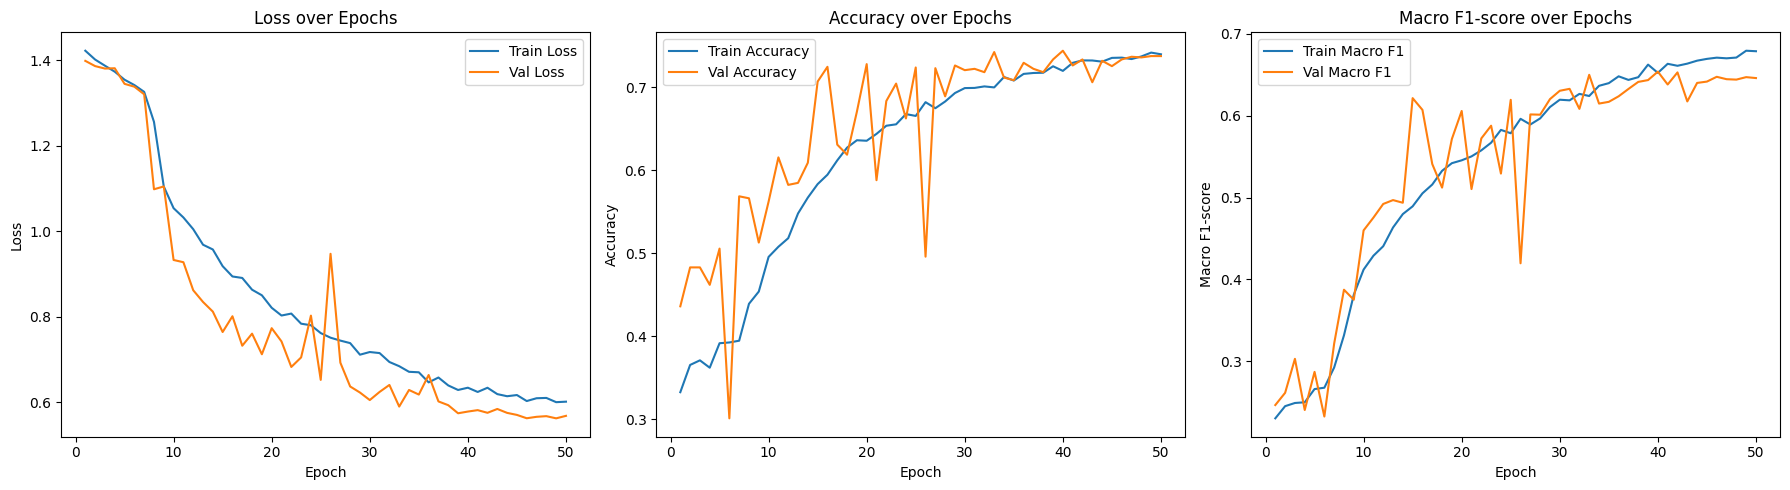

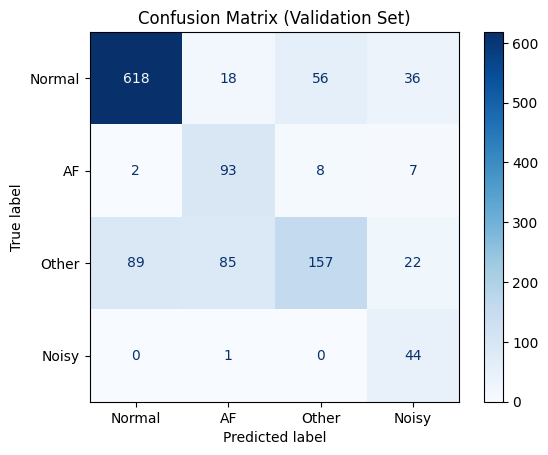

In [4]:
# Performance Measure Visualizations

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Training History Visualization

def plot_training_history(history):
    epochs = np.arange(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(18, 5))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    # Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()

    # Macro F1
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history["train_f1"], label="Train Macro F1")
    plt.plot(epochs, history["val_f1"], label="Val Macro F1")
    plt.xlabel("Epoch")
    plt.ylabel("Macro F1-score")
    plt.title("Macro F1-score over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Confusion Matrix Visualization on Validation Set

def plot_confusion_matrix(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for signals, labels, lengths in dataloader:
            signals = [s.to(device) for s in signals]
            labels = labels.to(device)
            outputs = model(signals, lengths)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix (Validation Set)")
    plt.show()


class_names = ["Normal", "AF", "Other", "Noisy"]
plot_confusion_matrix(model, val_loader, device, class_names)


In [5]:
X_test = read_zip_binary("../data/X_test.zip")
test_dataset = ECGTestDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=prep_test_batch)

model.eval()    # using model that is in the memory -- inference mode

# inference
# store every prediction into predictions list
predictions = []
with torch.no_grad():
    for signals, lengths in test_loader:
        signals = [s.to(device) for s in signals]
        outputs = model(signals, lengths)
        preds = outputs.argmax(dim=1)
        predictions.extend(preds.cpu().numpy())

# save to csv file
pd.DataFrame(predictions).to_csv("../csvs/augment.csv", index=False, header=False)